In [241]:
import numpy as np
from scipy.misc import derivative
from scipy.optimize import approx_fprime
from pandas_datareader import data
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import cvxopt as opt  
from cvxopt import blas, solvers  

In [279]:
stocks = ["UN", "AAPL","IBM","MSFT","FB","AAPL","MMM","ABT","ALLE","AAP"]

In [280]:
prices = data.DataReader(stocks, 
                       start='2015-1-1', 
                       end='2015-12-31', 
                       data_source='yahoo')['Adj Close']
returns = prices.pct_change().dropna()

In [282]:
prices_oos = data.DataReader(stocks, 
                       start='2016-1-1', 
                       end='2016-7-1', 
                       data_source='yahoo')['Adj Close']

returns_oos = prices_oos.pct_change().dropna()

In [260]:
returns.head()

Symbols,AAP,AAPL,ABT,ALLE,FB,IBM,MMM,MSFT,UN
Date,,,,,,,,,
2015-01-05,-0.013181,-0.028172,0.000223,-0.001998,-0.016061,-0.015735,-0.022553,-0.009196,-0.025310
2015-01-06,-0.000703,0.000094,-0.011356,-0.001638,-0.013473,-0.021566,-0.010663,-0.014678,-0.002650
2015-01-07,0.021489,0.014022,0.008108,0.013674,0.000000,-0.006536,0.007249,0.012705,0.013549
2015-01-08,0.008766,0.038422,0.020554,0.013489,0.026658,0.021735,0.023967,0.029418,0.021232
2015-01-09,-0.005089,0.001072,-0.010508,-0.008341,-0.005628,0.004355,-0.012284,-0.008405,-0.010010


In [447]:
def factor_exposure(returns, weights):

    correct_weights = abs(weights)/np.sum(abs(weights))
        
    weighted_port = [w*returns.iloc[:,i].values 
                     for i, w in enumerate(correct_weights)]

    pca = PCA()
    factors = pca.fit_transform(weighted_port)
    
    return pca.explained_variance_ratio_

In [398]:
def training_loss(weights):
    
    exposure = factor_exposure(returns, weights)
    
    uniform = 1/len(exposure)
    target = np.ones(len(exposure)) * uniform
    
    probs = exposure * target + (1 - exposure) * (1 - target)
    
    return -np.sum(np.log(probs))    

In [479]:
def optimize_weights(returns, iterations=100):
    
    weights = np.ones(returns.shape[1])/returns.shape[1]
    epsilon = np.ones(len(weights))*1e-6

    losses = [training_loss(weights)]

    for i in range(iterations):
        gradients = approx_fprime(weights, training_loss, epsilon=epsilon)
        weights -= gradients

        losses.append(training_loss(weights))

    correct_weights = abs(weights)/np.sum(abs(weights))
    
    return correct_weights

In [480]:
correct_weights = optimize_weights(returns)

<BarContainer object of 9 artists>

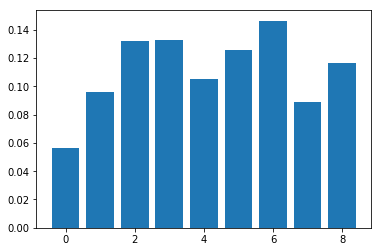

In [481]:
plt.bar(x=np.arange(len(correct_weights)), height=correct_weights)

<BarContainer object of 9 artists>

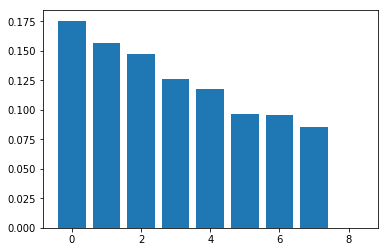

In [482]:
exposures = factor_exposure(returns, correct_weights)

plt.bar(x=np.arange(len(exposures)), height=exposures)

In [341]:
def allocation_over_time(returns, weights):
    
    alloc = [100 * weights]
    
    for t in range(returns.shape[0]):
        ret = returns.iloc[t,:].values
        alloc.append((1+ret)*alloc[-1])
                     
    return alloc

In [475]:
def exposures_losses_over_time(returns, returns_oos, weights):
    
    train_size = returns.shape[0]
    losses = []
    exposures = []
    
    for i in range(returns_oos.shape[0]):
        returns = returns.iloc[1:,:].append(returns_oos.iloc[i,:])

        exposure = factor_exposure(returns, weights)
    
        uniform = 1/len(exposure)
        target = np.ones(len(exposure)) * uniform

        probs = exposure * target + (1 - exposure) * (1 - target)
        
        losses.append(-np.sum(np.log(probs)))
        exposures.append(exposure)
        
    return losses, exposures

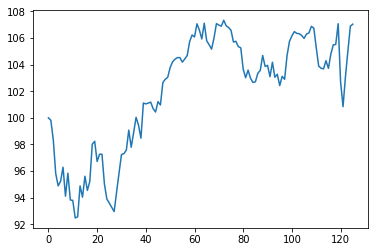

In [549]:
values = allocation_over_time(returns_oss, correct_weights)
port_values = np.array([sum(stock) for stock in values])
port_ret = (port_values[1:]-port_values[:-1])/port_values[:-1]
plt.plot(port_values)

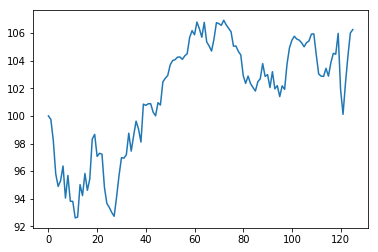

In [548]:
equal_weights = np.ones(returns_oos.shape[1])/returns_oos.shape[1]
values_eqw = allocation_over_time(returns_oos, equal_weights)
port_values_eqw = np.array([sum(stock) for stock in values_eqw])
port_ret_eqw = (port_values_eqw[1:]-port_values_eqw[:-1])/port_values_eqw[:-1]
plt.plot(port_values_eqw)

In [532]:
losses_t, exp_t = exposures_losses_over_time(returns, returns_oos, correct_weights)

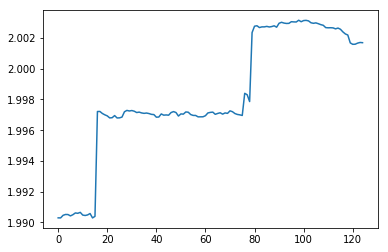

In [533]:
plt.plot(losses_t)

In [567]:
np.std(port_ret)*np.sqrt(252)

0.17113811909493296

In [568]:
np.std(port_ret_eqw)*np.sqrt(252)

0.17205526613269773

In [570]:
np.mean(port_ret)*252/(np.std(port_ret)*np.sqrt(252))

0.8875340853223997

In [571]:
np.mean(port_ret_eqw)*252/(np.std(port_ret_eqw)*np.sqrt(252))

0.7969845226455691